<a href="https://colab.research.google.com/github/ICT-Deeper/main/blob/main/%ED%86%B5%ED%95%A9%EC%BD%94%EB%93%9C_BIM_cifar10_both_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#BIM 소스코드
#BIM=Basic Iterative Method
#FGSM의 확장으로 FGSM을 여러번반복하면서 각 단계에서 생성된 적대적 예제에 조금씩 노이즈를 추가..
#여러번공격을

[INFO] loading CIFAR-10 dataset...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO] Compiling model...
[INFO] loading CIFAR-10 dataset...
[INFO] Compiling model...
[INFO] Training network...
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3759 - loss: 1.9604 - val_accuracy: 0.4875 - val_loss: 1.4779
[INFO] Evaluating network...
[INFO] Loss: 1.4779, Accuracy: 0.4875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


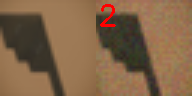

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


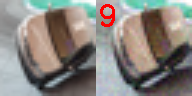

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


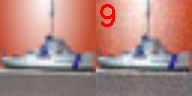

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


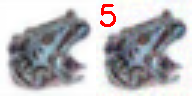

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


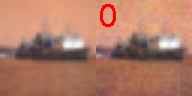

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


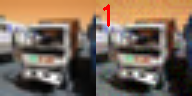

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


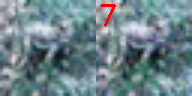

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


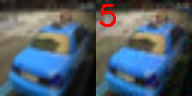

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


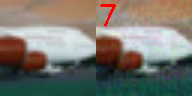

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


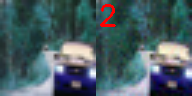

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import MSE
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, Flatten, Dropout, Dense
from google.colab.patches import cv2_imshow

# SimpleCNN 모델 정의
class SimpleCNN:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # 첫 번째 CONV => RELU => BN layer set
        model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))

        # 두 번째 CONV => RELU => BN layer set
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))

        # 첫 번째 (그리고 유일한) FC => RELU layer set
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

# Adversarial Sampler 클래스 정의
class AdvSampler():
    def __init__(self, dataset_type=0, model_type=1, name='abc'):
        self.dataset_type = dataset_type
        self.model_type = model_type
        self.name = name
        self.Initialize()


    # 초기화 함수
    def Initialize(self):
        self.load_dataset()
        self.data_preprocessing()
        self.build_model()

    # CIFAR-10 데이터셋 로드
    def load_dataset(self):
        if self.dataset_type == 0:
            print("[INFO] loading CIFAR-10 dataset...")
            (self.trainX, self.trainY), (self.testX, self.testY) = cifar10.load_data()

    # 데이터 전처리
    def data_preprocessing(self):
        self.trainX = self.trainX / 255.0
        self.testX = self.testX / 255.0
        self.trainY = to_categorical(self.trainY, 10)
        self.testY = to_categorical(self.testY, 10)

    def build_model(self):
        if self.dataset_type == 0:
            self.model = SimpleCNN.build(width=32, height=32, depth=3, classes=10) # 간단한 CNN 모델 정의

        print("[INFO] Compiling model...")
        self.opt = Adam(learning_rate=1e-3)
        self.model.compile(loss='categorical_crossentropy', optimizer=self.opt, metrics=['accuracy'])

    def train_evaluate_model(self, epochs=1, batch_size=64):
        print("[INFO] Training network...")
        self.model.fit(self.trainX, self.trainY, validation_data=(self.testX, self.testY), batch_size=batch_size, epochs=epochs, verbose=1)

        print("[INFO] Evaluating network...")
        (loss, acc) = self.model.evaluate(x=self.testX, y=self.testY, verbose=0)
        print(f"[INFO] Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    # BIM 공격을 통해 적대적 예제 생성
    #BIM구현을 위해 nun_iter라는 변수를 추가하여 FGSM을 여러 번 반복 적용..
    # alpha크기만큼 업데이트 되며, 전체 노이즈 크기는 eps를 넘지 않도록 제한
    def generate_adversary(self, image, label, eps=2 / 255.0, alpha=1 / 255.0, num_iter=10):
        image = tf.cast(image, tf.float32)
        perturbed_image = image

        for i in range(num_iter):
            with tf.GradientTape() as tape:
                tape.watch(perturbed_image)
                pred = self.model(perturbed_image)
                loss = MSE(label, pred)

            gradient = tape.gradient(loss, perturbed_image)
            signedGrad = tf.sign(gradient)

            perturbed_image = perturbed_image + alpha * signedGrad
            perturbation = tf.clip_by_value(perturbed_image - image, -eps, eps)
            perturbed_image = tf.clip_by_value(image + perturbation, 0, 1)

        return perturbed_image

    # 적대적 예제 생성 및 GAN 복원
    #BIM관련 매게변수를 전달해서 적대적 예제 생성
    def my_generator(self, max_iterations=100, num_iter=10, alpha=2/255.0):
        for i in np.random.choice(np.arange(0, len(self.testX)), size=(10,)):
            image = self.testX[i]
            label = self.testY[i]
            adversary = image.reshape(1, 32, 32, 3)

            iteration = 0
            while iteration < max_iterations:
                adversary = self.generate_adversary(adversary, label, eps=8/255.0, alpha=alpha, num_iter=num_iter)
                pred = self.model.predict(adversary)
                adversaryPred = pred[0].argmax()

                if adversaryPred != label.argmax():
                    break

                iteration += 1



            adversary = tf.reshape(adversary,(32, 32, 3)) * 255
            adversary = np.clip(adversary.numpy(), 0, 255).astype("uint8")

            image = image.reshape((32, 32, 3)) * 255
            image = image.astype("uint8")

            image = cv2.resize(image, (96, 96))
            adversary = cv2.resize(adversary, (96, 96))

            imagePred = label.argmax()
            adversaryPred = pred[0].argmax()
            color = (0, 255, 0)
            if imagePred != adversaryPred:
                color = (0, 0, 255)

            cv2.putText(adversary, str(adversaryPred), (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)


            output = np.hstack([image, adversary])
            cv2_imshow(output)
            cv2.waitKey(0)

# 실행
    def run(self):
      self.train_evaluate_model()
      self.my_generator()

result = AdvSampler(name='test')
result.Initialize()
result.run()
